<a href="https://colab.research.google.com/github/shahriarivari/Persian_sentiment_analysis/blob/main/BERT_notebooks/Fine_tune_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##pip installs

In [1]:
!pip install tokenizers
!pip install datasets
!pip install -U accelerate
!pip install -U transformers
!pip install hazm
!pip install stopwords_guilannlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 24.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.

##import libraries

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , Dataset

from transformers import BertTokenizerFast
from transformers import BertModel, BertConfig

import numpy as np
import pandas as pd
import codecs

# Preprocessing
from stopwords_guilannlp import stopwords_output
from hazm import *

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import plot_model
# Measuring metrics
from sklearn.metrics import f1_score

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


##Import and analyze SA Dataset

In [3]:
test = pd.read_csv('test.csv', index_col=None, header=None, encoding="utf-8")

In [4]:
x_test = test[0]
y_test = test[1]
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of testing sentence:  (1854,)
Number of testing label:  (1854,)


In [5]:
# create a binarray dataset since the dataset has mutiple labels

binary_y_test = []
binary_x_test = []
for i, y in enumerate(y_test):
  if int(y) != 0:
    if int(y) > 0:
      binary_y_test.append(1)
      binary_x_test.append(x_test[i])
    else:
      binary_y_test.append(0)
      binary_x_test.append(x_test[i])

# convert them into np arrays
x_test = np.asarray(binary_x_test)
y_test = np.asarray(binary_y_test)

##Import other datasets for sentiment analysis

In [7]:
# importing othere datasets
original = pd.read_csv('original.csv', index_col=None, header=None, encoding="utf-8")
balanced = pd.read_csv('balanced.csv', index_col=None, header=None, encoding="utf-8")
translation = pd.read_csv('translation.csv', index_col=None, header=None, encoding="utf-8")

In [8]:
# we select a dataset to work with
# selected_dataset = original
# using all of the dataset
stacked_df = pd.concat([original, balanced, translation], ignore_index=True)
# shuffle the dataframe
selected_dataset = stacked_df.sample(frac=1).reset_index(drop=True)

In [9]:
# creating train data
x_train = selected_dataset[0]
y_train = selected_dataset[1]
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)

Number of training sentence:  (26630,)
Number of training label:  (26630,)


In [10]:
# again make our dataset binarray
binary_y_train = []
binary_x_train = []
for i, y in enumerate(y_train):
  if int(y) != 0:
    if int(y) > 0:
      binary_y_train.append(1)
      binary_x_train.append(x_train[i])
    else:
      binary_y_train.append(0)
      binary_x_train.append(x_train[i])

# Convert dataframes to numpy arrays
x_train = np.asarray(binary_x_train)
y_train = np.asarray(binary_y_train)

##Plot some information about our downstream task dataset

{1: 14395, 0: 3826}


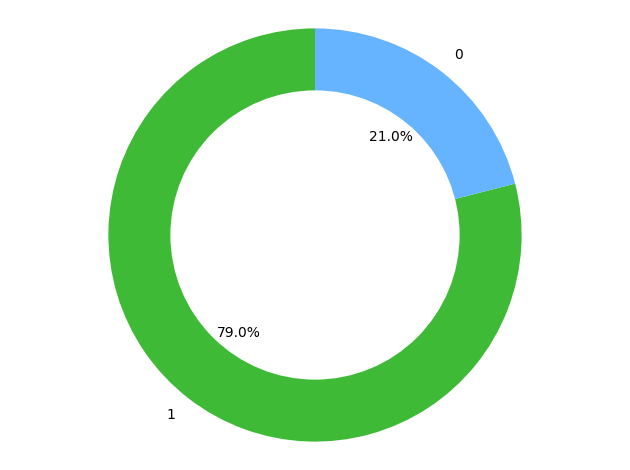

In [11]:
from collections import Counter

# See the data number of sentence in each category
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('distribution.png')
plt.show()


##Preprocessing

In [12]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)
    # tokens = [w for w in tokens if not w in stop_set]    # Remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = ' '.join(tokens)
    return tokens

In [13]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

##Load the pretrained model and tokenizer

In [ ]:
# mount to google drive
import zipfile
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
zip_file_path = '/content/drive/MyDrive/bert_pretrained_model.zip'
# Create a directory to extract the contents
extract_path = '/content/bert_pretrained_model/'
os.makedirs(extract_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [17]:
# mount to google drive
import zipfile

# Create a directory to extract the contents
extract_path = '/content/bert_pretrained_model/'
os.makedirs(extract_path, exist_ok=True)
# Extract the contents of the zip file
zip_file_path = '/content/bert_pretrained_model.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [52]:
# Load the saved BERT model
bert_model = BertModel.from_pretrained(os.path.join("bert_pretrained_model", "final_model"))

Some weights of BertModel were not initialized from the model checkpoint at bert_pretrained_model/final_model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
tokenizer_output_dir = "bert_tokenizer"
os.mkdir(tokenizer_output_dir)

In [20]:
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(tokenizer_output_dir, max_len = 256)

##classifiers

###MLP

In [21]:
# Define your MLP classifier
class MLPClassifier(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        # nn.Linear(hidden_size, 32),
        # nn.ReLU(),
        nn.Linear(hidden_size, output_size),
        #nn.Sigmoid()
    )

  def forward(self, x):
    return self.mlp(x)

##tokenizing data

In [22]:
# Tokenize train_docs and test_docs using the trained tokenizer
train_tokenized = tokenizer(train_docs.tolist(),max_length=256, truncation=True, padding=True,
                            return_tensors='pt')

test_tokenized = tokenizer(test_docs.tolist(),max_length=256, truncation=True, padding=True,
                           return_tensors='pt')

###create a dataset object

In [23]:
# Create custom dataset
class CustomDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": self.inputs["input_ids"][idx],
            "attention_mask": self.inputs["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.float32)
        }

###Create datalaoders

In [24]:
batch_size = 64
# Create DataLoader
train_dataset = CustomDataset(train_tokenized, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader
test_dataset = CustomDataset(test_tokenized, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##Initialize MLP Classifier and Define Loss Function and Optimizer

In [53]:
# Initialize MLP classifier
input_size = bert_model.config.hidden_size  # Get the size of the pooled representation
hidden_units = 128  # Adjust as needed
output_size = 1  # Binary classification, 1 output unit
learning_rate = 0.01
torch.manual_seed(42)
classifier = MLPClassifier(input_size=input_size, hidden_size=hidden_units, output_size=output_size)

# remove the pooler layer in bert
bert_model.pooler = None

# Move your model and data loaders to the selected device
bert_model.to(device)
classifier.to(device)

# Freeze all BERT layers
for param in bert_model.parameters():
    param.requires_grad = False

# BCE loss
criterion = torch.nn.BCEWithLogitsLoss()
# Specify the parameters to be optimized
optimizer = torch.optim.AdamW([{'params': classifier.parameters(), 'lr': learning_rate}])

##Training loop


In [54]:
accumulation_steps = 5  # Accumulate gradients over 8 batches
bert_output = []
classifier_output = []
input = []

bert_model.eval()

for epoch in range(5):

    train_loss = 0.0
    test_loss = 0.0
    print("epoch = ", epoch + 1)
    print("---------------------------------------")

    # Training
    for batch_idx, batch in enumerate(train_loader):
        inputs = batch["input_ids"].to(device)
        input.append(inputs)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        classifier.train()

        bert_outputs = bert_model(input_ids=inputs, attention_mask=attention_mask)
        bert_output.append(bert_outputs)
        bert_last_hidden_states = bert_outputs.last_hidden_state

        classifier_outputs = classifier(bert_last_hidden_states[:, 0, :])
        classifier_output.append(classifier_outputs)
        loss = criterion(classifier_outputs, labels.unsqueeze(dim=1))
        loss = loss / accumulation_steps  # Normalize the loss if using gradient accumulation
        loss.backward()

        # Update parameters every accumulation_steps batches
        if (batch_idx + 1) % accumulation_steps == 0 or batch_idx == len(train_loader) - 1:
            optimizer.zero_grad()
            optimizer.step()

        train_loss += loss.item()

    # Calculate average loss per batch for training
    train_loss = train_loss / len(train_loader)
    print(f"train loss per batch = {train_loss}")

    # Validation
    classifier.eval()

    with torch.inference_mode():
        for batch_idx, batch in enumerate(test_loader):
            inputs = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            bert_outputs = bert_model(input_ids=inputs, attention_mask=attention_mask)
            bert_last_hidden_states = bert_outputs.last_hidden_state
            classifier_outputs = classifier(bert_last_hidden_states[:, 0, :])
            loss = criterion(classifier_outputs, labels.unsqueeze(dim=1))
            test_loss += loss.item()

        # Calculate average loss per batch for testing
        test_loss = test_loss / len(test_loader)
        print(f"test loss per batch = {test_loss}")


epoch =  1
---------------------------------------
train loss per batch = 0.14189088339345496
test loss per batch = 0.7113478547996945
epoch =  2
---------------------------------------
train loss per batch = 0.14189088339345496
test loss per batch = 0.7113478547996945
epoch =  3
---------------------------------------
train loss per batch = 0.14189088339345496
test loss per batch = 0.7113478547996945
epoch =  4
---------------------------------------
train loss per batch = 0.14189088339345496
test loss per batch = 0.7113478547996945
epoch =  5
---------------------------------------
train loss per batch = 0.14189088339345496
test loss per batch = 0.7113478547996945


In [47]:
bert_output[9].last_hidden_state.mean(), bert_output[9].last_hidden_state.std()

(tensor(0.0006, device='cuda:0'), tensor(1.0030, device='cuda:0'))

In [49]:
bert_output[0].last_hidden_state.mean() , bert_output[0].last_hidden_state[:,0,:].shape

(tensor(0.0006, device='cuda:0'), torch.Size([64, 64]))